# Use `ocetrac-dask` to identify and track marine heatwaves
This example using 40 years of Daily outputs at 0.25° resolution takes ~6 minutes on 128 total cores.

In [1]:
import xarray as xr
import numpy as np
import dask
import ocetrac_dask

from tempfile import TemporaryDirectory
from getpass import getuser
from pathlib import Path
from dask.distributed import Client, LocalCluster
import subprocess
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
scratch_dir = Path('/scratch') / getuser()[0] / getuser() / 'mhws' 

## Start Dask Cluster

In [3]:
cluster_scratch = Path('/scratch') / getuser()[0] / getuser() / 'clients'
dask_tmp_dir = TemporaryDirectory(dir=cluster_scratch)
dask.config.set(temporary_directory=dask_tmp_dir.name)

## Local Cluster
cluster = LocalCluster(n_workers=64, threads_per_worker=2)
client = Client(cluster)

remote_node = subprocess.run(['hostname'], capture_output=True, text=True).stdout.strip().split('.')[0]
port = re.search(r':(\d+)/', client.dashboard_link).group(1)
print(f"Forward with Port = {remote_node}:{port}")

client.dashboard_link

Forward with Port = l40034:8787


'http://127.0.0.1:8787/status'

## Load Pre-processed Data
(cf. `01_preprocess_dask.ipynb`)

In [4]:
chunk_size = {'time': 25, 'lat': -1, 'lon': -1}
time_subset = slice(0,-1)
ds = xr.open_zarr(str(scratch_dir / '01_preprocess_dask.zarr'), chunks=chunk_size).isel(time=time_subset)

## Make into Binary Data & Make Mask

In [5]:
binary_out = np.isfinite(ds.features_notrend).persist()
binary_out

<xarray.DataArray 'features_notrend' (time: 13878, lat: 721, lon: 1440)> Size: 14GB
dask.array<isfinite, shape=(13878, 721, 1440), dtype=bool, chunksize=(25, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
    decimal_year  (time) float64 111kB dask.array<chunksize=(25,), meta=np.ndarray>
  * lat           (lat) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * lon           (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time          (time) datetime64[ns] 111kB 2002-01-01T23:59:00 ... 2039-12...

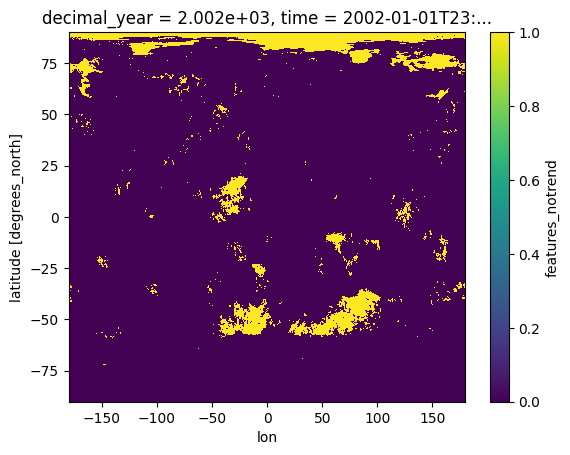

In [6]:
binary_out.isel(time=0).plot()

In [7]:
mask = ds.mask.where((ds.lat<85) & (ds.lat>-90), drop=False, other=0).persist()
mask

<xarray.DataArray 'mask' (lat: 721, lon: 1440)> Size: 8MB
dask.array<where, shape=(721, 1440), dtype=int64, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8

## Run Tracker

In [8]:
# Tracking Parameters
threshold_percentile = 0.95
min_size_quartile = 0.5

In [9]:
%%time
tracker = ocetrac_dask.Tracker(binary_out, mask, radius=8, min_size_quartile=min_size_quartile, timedim='time', xdim='lon', ydim='lat', positive=True)
blobs = tracker.track()

minimum area: 748.0
inital objects identified 	 344005
final objects tracked 	 16497
CPU times: user 3min 31s, sys: 24.9 s, total: 3min 56s
Wall time: 5min 5s


In [10]:
blobs.attrs

{'inital objects identified': 344005,
 'final objects tracked': 16497,
 'radius': 8,
 'size quantile threshold': 0.5,
 'min area': 748.0,
 'percent area reject': 0.09173237669123473,
 'percent area accept': 0.9082676233087653}

## Save Blobs

In [11]:
blobs.to_netcdf(scratch_dir / '02_tracked_dask.nc', mode='w')